In [1]:
%matplotlib inline
import numpy as np
from matplotlib import pyplot as plt

from xdgmm import XDGMM

from sklearn.model_selection import validation_curve
from sklearn.model_selection import ShuffleSplit

from test_plots import *

'''
Due to AstroML still using the deprecated GMM class from 
scikit-learn (instead of GaussianMixture), this demo will 
throw numerous errors whenever the XDGMM object calls 
an AstroML method, such as fit. The lines below will 
suppress these warnings; comment them out to see everything.

This XDGMM class has been updated to use GaussianMixture 
instead of GMM when necessary, but since it uses an AstroML
XDGMM object to store and manipulate the model, it is 
dependent on AstroML. These warnings will continue to occur 
until the XDGMM class from AstroML has been updated.
'''
import warnings
warnings.filterwarnings('ignore')

In [2]:
def plot_sphere(w=0, center=[0,0,0], r=[1, 1, 1], rotation=[1,1,1], ax=None):
    '''
        plot a sphere surface
        Input:
            c: 3 elements list, sphere center
            r: 3 element list, sphere original scale in each axis ( allowing to draw elipsoids)
            subdiv: scalar, number of subdivisions (subdivision^2 points sampled on the surface)
                    是椭球的分辨率
            ax: optional pyplot axis object to plot the sphere in.
            sigma_multiplier: sphere additional scale (choosing an std value when plotting gaussians)
        Output:
            ax: pyplot axis object
    '''

    if ax is None:
        fig = plt.figure()
        ax = fig.add_subplot(111, projection='3d')
    u = np.linspace(0, 2 * np.pi, 30)   #np.linspace 取等差数列
    v = np.linspace(0, np.pi, 30)
    x = r[0] * np.outer(np.cos(u), np.sin(v))
    y = r[1] * np.outer(np.sin(u), np.sin(v))
    z = r[2] * np.outer(np.ones(np.size(u)), np.cos(v))

    for i in range(len(x)):
        for j in range(len(x)):
            #[x[i, j], y[i, j], z[i, j]] = [x[i, j], y[i, j], z[i, j]] + center #spherical专用
            [x[i, j], y[i, j], z[i, j]] = np.dot([x[i, j], y[i, j], z[i, j]], rotation.T) + center

    ax.plot_surface(x, y, z, alpha=0.3, linewidth=0, antialiased=False)

    return ax

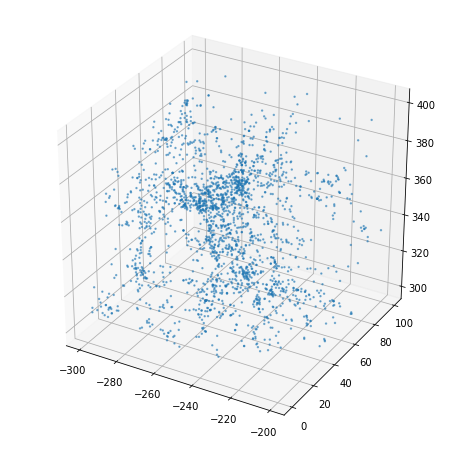

In [46]:
A=np.load("/Users/mahaixia/DATA/SDSS_DR7/galaxy_DR7/SDSS_box_bins100.npz")
data = A["a7"]
points=data[:,4:7]

fig = plt.figure(figsize=(8, 8))
axes = fig.add_subplot(111, projection='3d')
# axes.set_zlim3d(200, 250)
# axes.set_xlim3d(-150, -100)
# axes.set_ylim3d(50, 100)
axes.scatter(points[:,0], points[:,1], points[:,2], s = 2.0, alpha = 0.5)

Xerr = np.zeros(points.shape + points.shape[-1:])

In [4]:
# Instantiate an XDGMM model:
xdgmm = XDGMM(method='Bovy')

In [23]:
# Define the range of component numbers, and get ready to compute the BIC for each one:
param_range = np.arange(25, 35, 1)

# Loop over component numbers, fitting XDGMM model and computing the BIC:
bic, optimal_n_comp, lowest_bic = xdgmm.bic_test(points, Xerr, param_range, no_err=True)

KeyboardInterrupt: 

ValueError: shape mismatch: objects cannot be broadcast to a single shape

<Figure size 432x288 with 0 Axes>

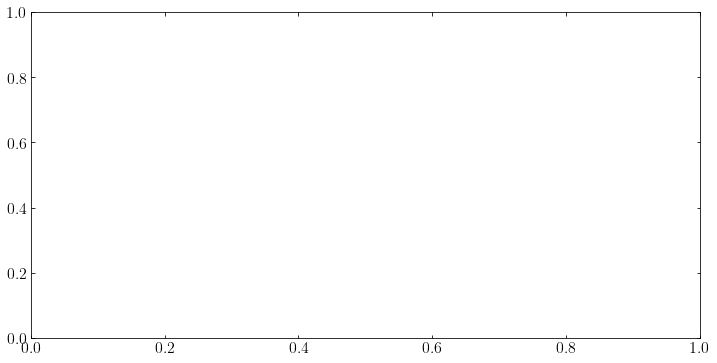

In [18]:
plot_bic(param_range, bic, optimal_n_comp)

## Model Fitting

Now that we know the best number of components to use, we can fit the data. First set the number of components, then perform the fit.

In [47]:
# xdgmm.n_components = optimal_n_comp
# xdgmm.n_components = 31   # a0
# xdgmm.n_components = 36   # a1
# xdgmm.n_components = 54   # a2
# xdgmm.n_components = 54   # a3
# xdgmm.n_components = 78   # a4
# xdgmm.n_components = 60   # a5
# xdgmm.n_components = 66   # a6
xdgmm.n_components = 35   # a7

xdgmm = xdgmm.fit(points, Xerr)
print("xdgmm fitting: done!")

index = xdgmm.predict(points, Xerr)

xdgmm fitting: done!


In [25]:
def find_fraction(points, center=[0,0,0], r=[1, 1, 1], rotation=[1,1,1]):
    inner = 0.0
    outer = 0.0
    midx = []
    x = points[:,4] - center[0]
    y = points[:,5] - center[1]
    z = points[:,6] - center[2]
    r = r   # 1 sigma球
    for j in range(len(x)):
        [x[j], y[j], z[j]] = np.dot([x[j], y[j], z[j]], np.linalg.inv(rotation))
    for i in range(points.shape[0]):
        distance = np.square(x[i]/r[0]) + np.square(y[i]/r[1]) + np.square(z[i]/r[2])
        if distance > 1.0:
            outer +=1.0
        elif distance < 1.0:
            inner +=1.0
            midx.append(points[i])

    return inner, outer, midx

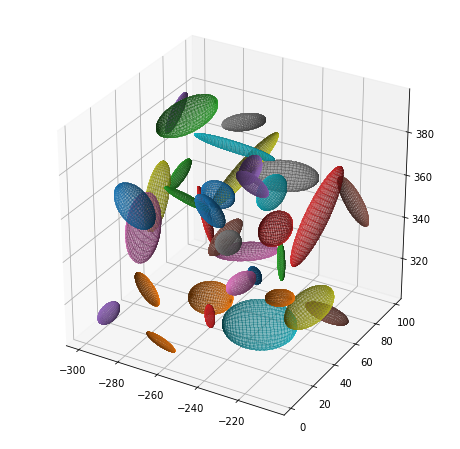

In [48]:
figxd = plt.figure(figsize=(8, 8))
axesxd = figxd.add_subplot(111, projection='3d')

index = xdgmm.predict(points, Xerr)

member = []
N_member = []
for i in range(xdgmm.n_components):
    covariances = xdgmm.V[i][:3, :3]
    v, u = np.linalg.eigh(covariances)
    r = np.sqrt(v)
    plot_sphere(xdgmm.weights[i], xdgmm.mu[i], r, u, ax=axesxd)
    group = data[np.where(index == i)]
    inner, outer, mlist = find_fraction(group, center=xdgmm.mu.T[:3,i], r=r, rotation=u)
    member.append(mlist)
    N_member.append(inner)

(array([13.,  9.,  5.,  2.,  2.,  0.,  1.,  1.,  0.,  2.]),
 array([ 0. ,  3.5,  7. , 10.5, 14. , 17.5, 21. , 24.5, 28. , 31.5, 35. ]),
 <a list of 10 Patch objects>)

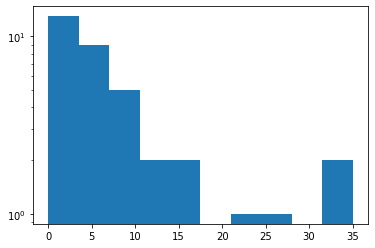

In [49]:
plt.yscale("log")
plt.hist(N_member)

In [50]:
with open("Groups_bins100.txt", "ab") as f: 
    np.savetxt(f,np.c_[np.array(N_member).T, xdgmm.mu[:, :3]], fmt=' '.join(['%i'] + ['%1.5f']*3))

## Gaussian 置信区间